In [3]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils

In [4]:
register_matplotlib_converters()

%matplotlib notebook
%matplotlib inline

# Options

In [5]:
_SYMBOL = 'KO'
_DATE = '2020-03-18'

In [6]:
query = f"""
    select *
    from td.equities
    where symbol = '{_SYMBOL}'
        and market_datetime::date = '{_DATE}'
    limit 10
    """
stocks = utils.query_db(query=query)
stocks.head(3).T

,0
symbol,KO
open,44.74
high,45.15
low,41.59
close,44.85
volume,3.54083e+07
market_datetime_epoch,1584507600000.0
empty,False
market_datetime,2020-03-18 05:00:00
file_datetime,2020-04-19 00:09:51


In [7]:
query = f"""
    select
        symbol
        , put_call
        , put_call = 'CALL' as is_call
        , description
        , bid
        , ask
        , last
        , close_price
        , total_volume
        , open_interest
        , strike
        , days_to_expiration
        , expiration_date_from_epoch::date
        , file_datetime::date
    from td.options
    where file_datetime::date = '{_DATE}'
        and symbol = '{_SYMBOL}'
    order by put_call, days_to_expiration, strike
    """
options = utils.query_db(query=query)
options.head(3).T

,0,1,2
symbol,KO,KO,KO
put_call,CALL,CALL,CALL
is_call,True,True,True
description,KO Mar 20 2020 30 Call,KO Mar 20 2020 32.5 Call,KO Mar 20 2020 35 Call
bid,14.5,12.1,9.5
ask,19.4,16.6,14.25
last,0,14.58,10.97
close_price,17.18,14.68,12.21
total_volume,0,0,0
open_interest,0,3,0


In [8]:
_strike = np.median(options['strike'].unique())
_expiration = np.sort(options['days_to_expiration'].unique())[7]

_OPTION_PRICE_COL = 'ask'
_options = options.loc[
    (options['open_interest']>0) 
    & (options['put_call']=='CALL')
    & (options['days_to_expiration']==_expiration) 
].copy()

_options['break_even'] = _options['strike'] + _options[_OPTION_PRICE_COL]
_options['distance'] = _options['break_even'] - stocks['open'].values

_options.head()

,symbol,put_call,is_call,description,bid,ask,last,close_price,total_volume,open_interest,strike,days_to_expiration,expiration_date_from_epoch,file_datetime,break_even,distance
300,KO,CALL,True,KO May 15 2020 35 Call,10.80,13.75,14.25,13.75,0.0,3.0,35.0,58.0,2020-05-15,2020-03-18,48.75,4.01
302,KO,CALL,True,KO May 15 2020 40 Call,7.05,10.85,8.63,9.44,0.0,278.0,40.0,58.0,2020-05-15,2020-03-18,50.85,6.11
303,KO,CALL,True,KO May 15 2020 42.5 Call,6.00,8.70,7.35,7.33,0.0,152.0,42.5,58.0,2020-05-15,2020-03-18,51.20,6.46
304,KO,CALL,True,KO May 15 2020 45 Call,5.15,5.70,5.31,5.22,0.0,317.0,45.0,58.0,2020-05-15,2020-03-18,50.70,5.96
305,KO,CALL,True,KO May 15 2020 47.5 Call,2.62,4.15,3.75,3.56,0.0,241.0,47.5,58.0,2020-05-15,2020-03-18,51.65,6.91


### Out of moneyness

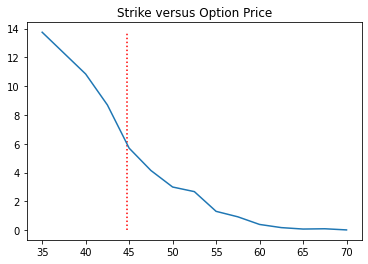

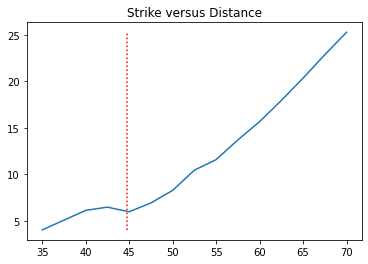

In [9]:
plt.title('Strike versus Option Price')
plt.plot(_options['strike'], _options[_OPTION_PRICE_COL])
plt.vlines(
    stocks['open'],
    ymin=_options[_OPTION_PRICE_COL].min(),
    ymax=_options[_OPTION_PRICE_COL].max(),
    colors='r',
    linestyles='dotted'
)
plt.show()

plt.title('Strike versus Distance')
plt.plot(_options['strike'], _options['distance'])
plt.vlines(
    stocks['open'],
    ymin=_options['distance'].min(),
    ymax=_options['distance'].max(),
    colors='r',
    linestyles='dotted'
)
plt.show()

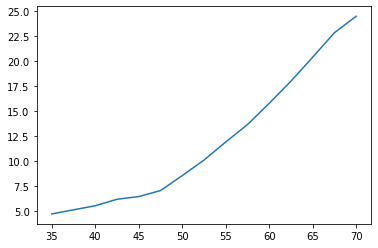

In [10]:
plt.plot(
    _options['strike'], 
    (
        (
            _options['distance']
            + _options['distance'].shift(1, fill_value=_options['distance'].min())
            + _options['distance'].shift(-1, fill_value=_options['distance'].max())
        )/3
    )
)
plt.show()

### Put call parity

In [34]:
# call and put cols
_options = options.copy()
_options['call_ask'] = _options.apply(lambda x: x['ask'] if x['is_call'] else 0, axis=1)
_options['put_ask'] = _options.apply(lambda x: x['ask'] if not x['is_call'] else 0, axis=1)

In [41]:
# aggregation
_groups = ['symbol', 'strike', 'days_to_expiration', 'expiration_date_from_epoch']
_aggs = {'call_ask': 'max', 'put_ask': 'max'}
parity = _options.groupby(_groups).agg(_aggs)

parity['forward'] = parity['call_ask'] - parity['put_ask']
parity['cumulative_premium'] = parity['call_ask'] + parity['put_ask']
parity = parity.reset_index()

parity['forward_discount'] = parity['forward'] - (stocks['open'].values - parity['strike'])
parity.head()

,symbol,strike,days_to_expiration,expiration_date_from_epoch,call_ask,put_ask,forward,cumulative_premium,forward_discount
0,KO,22.5,58.0,2020-05-15,26.95,1.49,25.46,28.44,3.22
1,KO,22.5,156.0,2020-08-21,27.25,0.81,26.44,28.06,4.20
2,KO,22.5,275.0,2020-12-18,27.25,1.08,26.17,28.33,3.93
3,KO,22.5,674.0,2022-01-21,27.50,3.80,23.70,31.30,1.46
4,KO,23.0,93.0,2020-06-19,26.70,1.00,25.70,27.70,3.96


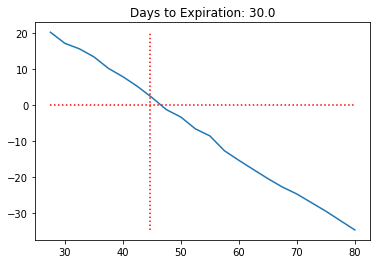

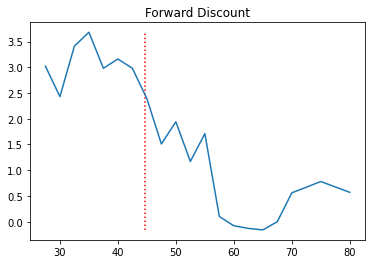

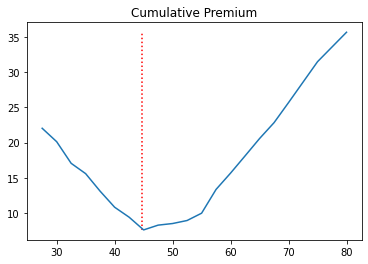

In [45]:
_N_EXPIRATION = 4
_expiration = np.sort(parity['days_to_expiration'].unique())[_N_EXPIRATION]
_s = parity[parity['days_to_expiration'] == _expiration]

plt.title(f'Days to Expiration: {_expiration}')
plt.plot(_s['strike'], _s['forward'])
plt.vlines(
    stocks['open'],
    ymin=_s['forward'].min(),
    ymax=_s['forward'].max(),
    colors='r',
    linestyles='dotted'
)
plt.hlines(
    0,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
    colors='r',
    linestyles='dotted'
)
plt.show()

plt.title('Forward Discount')
plt.plot(_s['strike'], _s['forward_discount'])
plt.vlines(
    stocks['open'],
    ymin=_s['forward_discount'].min(),
    ymax=_s['forward_discount'].max(),
    colors='r',
    linestyles='dotted'
)
plt.show()

plt.title('Cumulative Premium')
plt.plot(_s['strike'], _s['cumulative_premium'])
plt.vlines(
    stocks['open'],
    ymin=_s['cumulative_premium'].min(),
    ymax=_s['cumulative_premium'].max(),
    colors='r',
    linestyles='dotted'
)
plt.show()

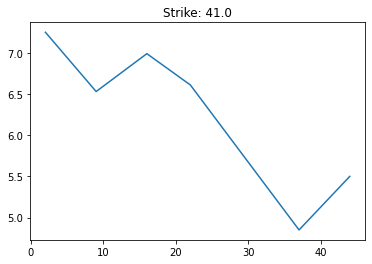

In [43]:
_N_STRIKE = 12
_strike = np.sort(parity['strike'].unique())[_N_STRIKE]
_e = parity[parity['strike'] == _strike]

plt.title(f'Strike: {_strike}')
plt.plot(_e['days_to_expiration'], _e['forward'])
plt.show()

### Forward pricing

In [46]:
parity.head()

,symbol,strike,days_to_expiration,expiration_date_from_epoch,call_ask,put_ask,forward,cumulative_premium,forward_discount
0,KO,22.5,58.0,2020-05-15,26.95,1.49,25.46,28.44,3.22
1,KO,22.5,156.0,2020-08-21,27.25,0.81,26.44,28.06,4.20
2,KO,22.5,275.0,2020-12-18,27.25,1.08,26.17,28.33,3.93
3,KO,22.5,674.0,2022-01-21,27.50,3.80,23.70,31.30,1.46
4,KO,23.0,93.0,2020-06-19,26.70,1.00,25.70,27.70,3.96


In [76]:
_COST_OF_CARRY = 0.0001
_RISK_FREE_RATE = 0.0001

def calc_forward_price(
    stock_price: float,
    strike_price: pd.Series,
    days_to_expiration: pd.Series,
    risk_free_rate: float,
    cost_of_carry: float,
) -> pd.Series:
    forward_price = (np.e ** -(risk_free_rate * days_to_expiration)) * (stock_price * np.e ** (cost_of_carry * days_to_expiration) - strike_price)
    return forward_price

parity['_forward'] = calc_forward_price(
    stock_price = stocks['open'].values,
    strike_price = parity['strike'],
    days_to_expiration = parity['days_to_expiration'],
    risk_free_rate = _RISK_FREE_RATE,
    cost_of_carry = _COST_OF_CARRY
)

parity['diff'] = parity['forward'] - parity['_forward']

parity[['strike', 'days_to_expiration', 'call_ask', 'put_ask', 'forward', '_forward', 'diff']].head(10)

,strike,days_to_expiration,call_ask,put_ask,forward,_forward,diff
0,22.5,58.0,26.95,1.49,25.46,22.370122,3.089878
1,22.5,156.0,27.25,0.81,26.44,22.588276,3.851724
2,22.5,275.0,27.25,1.08,26.17,22.850320,3.319680
3,22.5,674.0,27.50,3.80,23.70,23.706523,-0.006523
4,23.0,93.0,26.70,1.00,25.70,21.952908,3.747092
5,23.0,184.0,26.75,0.97,25.78,22.159330,3.620670
6,23.0,303.0,27.25,3.00,24.25,22.426448,1.823552
7,25.0,58.0,24.40,1.56,22.84,19.884580,2.955420
8,25.0,93.0,24.50,1.10,23.40,19.971422,3.428578
9,25.0,156.0,24.30,1.79,22.51,20.126974,2.383026
